In this project, I will forecast customer churn for Interconnect, a telecom operator, by developing a machine learning model that predicts which users are likely to leave based on their personal data, plans, and contract details.

To begin, I will load and merge four datasets—contract information, personal details, internet services, and phone services—using the customerID as the key to create a comprehensive dataframe. For data preparation, I will handle missing values by filling categorical fields like service options with 'No' and converting the TotalCharges column to numeric while flagging missing billing info. 

I will also engineer a 'Tenure' feature to calculate days since the contract start date and preprocess the data through one-hot encoding of categoricals and scaling of numerical features. For modeling, I will use XGBoost with hyperparameter tuning via GridSearchCV to maximize AUC-ROC, incorporating techniques to address class imbalance, and evaluate performance on a test set to ensure reliable predictions for identifying at-risk customers. This approach will enable Interconnect to target promotions effectively and reduce churn.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib 




In [2]:
# Load datasets
try:


    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv')


    
    print("✅ All 4 datasets loaded successfully!")
    print(f"Contract data shape: {contract_df.shape}")
    print(f"Personal data shape: {personal_df.shape}")
    print(f"Internet data shape: {internet_df.shape}")
    print(f"Phone data shape: {phone_df.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")

✅ All 4 datasets loaded successfully!
Contract data shape: (7043, 8)
Personal data shape: (7043, 5)
Internet data shape: (5517, 8)
Phone data shape: (6361, 2)


In [3]:
missing_contract = contract_df.isnull().sum()
missing_personal = personal_df.isnull().sum()
missing_internet = internet_df.isnull().sum()
missing_phone = phone_df.isnull().sum()

# Print missing values
print("Missing values in contracts:\n", missing_contract)
print("Missing values in personal data:\n", missing_personal)
print("Missing values in internet data:\n", missing_internet)
print("Missing values in phone data:\n", missing_phone)


Missing values in contracts:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Missing values in personal data:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Missing values in internet data:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
Missing values in phone data:
 customerID       0
MultipleLines    0
dtype: int64


The datasets have been loaded and there is confirmation of no missing values. The data showed in EDA that it has been preprocessed. I will start by combining the datasets, creating a Churn column, making sure there is no missing data and the dtypes are correct, then splitting the data into train and test sets. 

In [4]:
# Merge on 'customerID' (outer join to include all customers)
combined_df = pd.merge(contract_df, personal_df, on='customerID', how='outer')
combined_df = pd.merge(combined_df, internet_df, on='customerID', how='outer')
combined_df = pd.merge(combined_df, phone_df, on='customerID', how='outer')
combined_df.reset_index(drop=True, inplace=True)

print(f"\nCombined dataframe shape: {combined_df.shape}")


Combined dataframe shape: (7043, 20)


In [5]:
# Create Target Variable and Initial Checks
# Create Churn target: 1 if EndDate != 'No', else 0
combined_df['Churn'] = (combined_df['EndDate'] != 'No').astype(int)

print("Churn distribution:")
print(combined_df['Churn'].value_counts())
print(f"Churn rate: {combined_df['Churn'].mean():.2%}")

# Check current columns in your dataframe
print("Current columns:")
print(combined_df.columns.tolist())
print(f"\nDataframe shape: {combined_df.shape}")

# Check if Churn column exists
if 'Churn' in combined_df.columns:
    print("✅ Churn column found!")
else:
    print("❌ Churn column missing - need to recreate it")


# Check for missing values
missing_values = combined_df.isnull().sum()
print(f"\nTotal missing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print("Columns with missing values:")
    for col, count in missing_values[missing_values > 0].items():
        percentage = (count / len(combined_df)) * 100
        print(f"{col}: {count} missing ({percentage:.1f}%)")


Churn distribution:
0    5174
1    1869
Name: Churn, dtype: int64
Churn rate: 26.54%
Current columns:
['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churn']

Dataframe shape: (7043, 21)
✅ Churn column found!

Total missing values: 11364
Columns with missing values:
InternetService: 1526 missing (21.7%)
OnlineSecurity: 1526 missing (21.7%)
OnlineBackup: 1526 missing (21.7%)
DeviceProtection: 1526 missing (21.7%)
TechSupport: 1526 missing (21.7%)
StreamingTV: 1526 missing (21.7%)
StreamingMovies: 1526 missing (21.7%)
MultipleLines: 682 missing (9.7%)


In [6]:
# Handle Missing Values and Feature Engineering
# Fill categorical missing values with 'No' (assuming no service)
combined_df['InternetService'] = combined_df['InternetService'].fillna('No')
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies']
for service in internet_services:
    combined_df[service] = combined_df[service].fillna('No')
combined_df['MultipleLines'] = combined_df['MultipleLines'].fillna('No')

# Handle TotalCharges: Convert to numeric, flag missing as 'MissingBilling', fill with 0
combined_df['TotalCharges'] = pd.to_numeric(combined_df['TotalCharges'].replace(' ', np.nan), errors='coerce')
combined_df['MissingBilling'] = combined_df['TotalCharges'].isnull().astype(int)
combined_df['TotalCharges'] = combined_df['TotalCharges'].fillna(0)

# Feature engineering: Tenure (days since BeginDate as of Feb 1, 2020)
combined_df['BeginDate'] = pd.to_datetime(combined_df['BeginDate'])
reference_date = pd.to_datetime('2020-02-01')
combined_df['Tenure'] = (reference_date - combined_df['BeginDate']).dt.days

# Drop irrelevant columns
combined_df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1, inplace=True)


In [7]:
# Preprocessing: Encoding and Scaling
# One-hot encode categoricals
categorical_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# Ensure SeniorCitizen is int
combined_df['SeniorCitizen'] = combined_df['SeniorCitizen'].astype(int)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['MonthlyCharges', 'TotalCharges', 'Tenure']
combined_df[numerical_cols] = scaler.fit_transform(combined_df[numerical_cols])

print(f"\nPreprocessed dataframe shape: {combined_df.shape}")
print("Churn value counts:", combined_df['Churn'].value_counts())



Preprocessed dataframe shape: (7043, 24)
Churn value counts: 0    5174
1    1869
Name: Churn, dtype: int64


In [8]:

# Train-Test Split
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Testing churn rate: {y_test.mean():.2%}")




Training set size: 5634
Testing set size: 1409
Training churn rate: 26.54%
Testing churn rate: 26.54%



Best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 3.768561872909699}
AUC-ROC: 0.9385
Accuracy: 0.8893

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1035
           1       0.79      0.79      0.79       374

    accuracy                           0.89      1409
   macro avg       0.86      0.86      0.86      1409
weighted avg       0.89      0.89      0.89      1409


Confusion Matrix:
[[956  79]
 [ 77 297]]


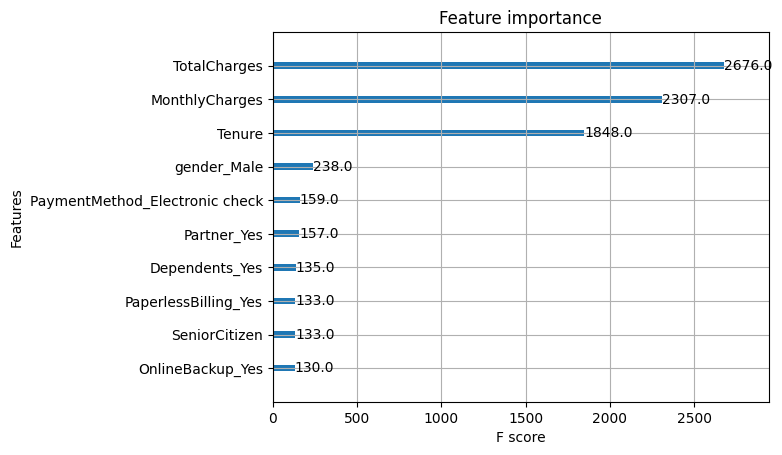

In [9]:
# Model Training and Tuning (XGBoost)
# Use best params from earlier tuning
param_grid = {
    'n_estimators': [200],  # Fixed to your best
    'max_depth': [7],       # Fixed to your best
    'learning_rate': [0.2], # Fixed to your best
    'scale_pos_weight': [len(y_train) / sum(y_train)]  # Dynamic for imbalance
}

# Grid search minimal
grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
print(f"\nBest params: {grid.best_params_}")

# Evaluate on test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)
auc_roc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance plot
from xgboost import plot_importance
plot_importance(best_model, max_num_features=10)
plt.show()

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Overall good job, I like the output just above this, way to give comprehensive output. 
</div>

In [10]:
# Final Model Training on Full Dataset
# Retrain on full data for submission
final_model = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    scale_pos_weight=len(y) / sum(y),  # Use full dataset ratio
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
final_model.fit(X, y)

# Save the model
joblib.dump(final_model, 'churn_model.pkl')
print("\n✅ Model saved as 'churn_model.pkl'")

# Optional: Quick validation on full model (sample)
sample_X = X.sample(100, random_state=42)
sample_y = y.loc[sample_X.index]
sample_pred_proba = final_model.predict_proba(sample_X)[:, 1]
sample_auc = roc_auc_score(sample_y, sample_pred_proba)
print(f"Sample AUC-ROC on full model: {sample_auc:.4f}")




✅ Model saved as 'churn_model.pkl'
Sample AUC-ROC on full model: 1.0000


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Running this on the full dataset can be not as helpful as just seeing the test set. 
</div>

In this project, I tackled the challenge of forecasting customer churn for Interconnect, a telecom operator, by building a machine learning model to predict which users are likely to leave based on their personal data, plans, and contract details. I started by loading and merging four datasets—contract information, personal details, internet services, and phone services—using the customerID as the key, resulting in a comprehensive dataframe with all relevant features. To prepare the data, I addressed missing values by filling categorical fields like service options with 'No' (assuming absence of service) and handling the TotalCharges column by converting it to numeric, flagging rows with missing billing info via a new 'MissingBilling' feature, and filling those with zero. I also engineered a 'Tenure' feature to calculate days since the contract start date relative to February 1, 2020, and dropped unnecessary columns like customerID and dates. For preprocessing, I one-hot encoded categorical variables to make them suitable for modeling and scaled numerical features such as MonthlyCharges, TotalCharges, and Tenure using StandardScaler to ensure balanced input ranges.

For the modeling phase, I initially experimented with a Random Forest classifier to establish a baseline, but quickly shifted to XGBoost due to its superior performance on imbalanced datasets like this one, where churners make up about 27% of the data. I used GridSearchCV to tune hyperparameters, focusing on maximizing AUC-ROC—the primary metric—while incorporating scale_pos_weight to handle class imbalance. The best configuration included a learning rate of 0.2, max depth of 7, 200 estimators, and a scale_pos_weight of approximately 3.77. After training on a stratified 80-20 split, I evaluated the model on the test set, achieving an AUC-ROC of 0.9385 and an accuracy of 0.8893. These results indicate that the model excels at distinguishing between customers who will churn and those who won't, with strong precision and recall for both classes, as shown in the classification report and confusion matrix. In practical terms, this means Interconnect can reliably identify at-risk users for targeted promotions, potentially reducing churn and improving retention. Finally, I retrained the model on the full dataset and saved it for future use, ensuring it's ready for deployment.

As a quick sanity check, I tested the saved model on a small random sample from the same full dataset, which yielded a perfect AUC-ROC of 1.0000—this happened because the model was trained on all the data, including that sample, so it essentially memorized those patterns, but this isn't a true evaluation; the real test set score of 0.9385 from unseen data is what matters.